In [2]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
#from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer, Vars, reset, trackerreset, datareset
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
#from lowEBMs.Packages.Variables import 
#from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs.Packages.Optimization import coremodule
import lowEBMs.Packages.Constants as const
from lowEBMs import update_plotstyle, moving_average
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [2]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
NORESM_1990_2005=SAT_VOLC-SAT_TREN

In [3]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [4]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
#labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func3','f'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
#P0=np.array([50*4.2e6,0.5,1.9e-15,0,1.165,1.165,1.165])
#Pmin=np.array([0.5*10*4.2e6,0.4,0.6e-15,-50,0.9,0.9,0.9])
#Pmax=np.array([100*4.2e6,0.6,5e-15,50,1.2,1.2,1.2])
#P_pert_ralative=[1/10000,1/10000,1/10000,1/10000,1/10000,1/10000]
#labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
#       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
#P0=np.zeros(18)
"""labels=[['eqparam','c_ao'],['func1','k'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,1,0.5,1.9e-15,1.165,1.165,1.165])
P0=np.array([3.7081e+08, 9.8089e-01, 4.8458e-01, 5.0000e-15, 1.1702e+00, 1.1674e+00, 1.1998e+00])
Pmin=np.array([1*4.2e6,0.9,0.4,0.5e-15,0.9,0.9,0.9])
Pmax=np.array([150*4.2e6,1.1,0.6,5e-15,1.3,1.3,1.3])"""

labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,210,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,3.3,1.3,1.3,1.3])
#Pmax=np.full(18,50)
#Pmin=np.full(18,-50)
#print(Pmax)
P_pert_ratio=1/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-5
maxlength=int(100)
targetmode='Coupled'
target={'GMT':NORESM_1990_2005,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.1
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini')
#print(config_CTRL)
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Budyko.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[17888.18999508 17888.1898724  17888.19011789 17889.14106855
 17887.23894713 17886.6077993  17889.77243915 17888.19064922
 17888.18934094 17888.19039401 17888.18959615 17888.19295096
 17888.18703911]
1e-08
[2.94000017e+08 2.29991440e+02 2.50051689e+00 1.16499996e+00
 1.16499998e+00 1.16499982e+00]
Iteration no.1


[17880.99337678 17880.99325416 17880.99349953 17881.94406046
 17880.04271862 17879.41223375 17882.57476789 17880.99403072
 17880.99272285 17880.99377551 17880.99297806 17880.99633175
 17880.99042173]
1.5531209417215246e-05
[2.94025766e+08 2.16702878e+02 3.30000000e+00 1.16493864e+00
 1.16496259e+00 1.16472272e+00]
Iteration no.2


[4002.92108031 4002.57494793 4003.26703769 4008.08262964 3997.75972029
 4000.56407539 4005.28016333 4002.94202092 4002.90010367 4002.92948619
 4002.91263856 4003.02271994 4002.81929405]
5.562223848129566e-06
[3.20036561e+08 1.90864629e+02 3.30000000e+00 1.16423478e+00
 1.16467969e+00 1.16130687e+00]
Iteration no.3


[35.39137754 35.39129021 35.39146495 35.42698157 35.35580048 35.40254574
 35.38021033 35.39152787 35.3912272  35.39142778 35.39132729 35.39218661
 35.3905685 ]
3.704274007547896e-06
[3.20040935e+08 1.90745975e+02 3.29864864e+00 1.16423142e+00
 1.16467856e+00 1.16128878e+00]
Iteration no.4


[34.58567521 34.58558773 34.58576279 34.62069576 34.55068167 34.59673161
 34.57461983 34.58582671 34.58552371 34.58572568 34.58562473 34.58648829
 34.58486216]
0.00023764715799896603
[3.20322035e+08 1.90000000e+02 3.21282021e+00 1.16401404e+00
 1.16460614e+00 1.16012215e+00]
Iteration no.5


[24.29905648 24.29895787 24.29915519 24.32700106 24.27114101 24.30859259
 24.28952195 24.29921329 24.29889967 24.29910722 24.29900574 24.29987784
 24.29823516]
0.00027893374603307216
[3.20693936e+08 1.90000000e+02 3.12593595e+00 1.16374995e+00
 1.16452069e+00 1.15873890e+00]
Iteration no.6


[18.68215895 18.6820471  18.68227091 18.70566942 18.65867999 18.69058213
 18.67373781 18.68231529 18.68200261 18.68220877 18.68210913 18.68296779
 18.68135017]
0.0003161036229208225
[3.21171947e+08 1.90000000e+02 3.03896830e+00 1.16345157e+00
 1.16442560e+00 1.15719525e+00]
Iteration no.7


[13.8445982  13.84447076 13.84472575 13.86286166 13.82636895 13.85158443
 13.83761459 13.84475668 13.84443972 13.84464774 13.84454866 13.84540471
 13.84379174]
0.00028447888681851186
[3.21662080e+08 1.90000000e+02 2.97405761e+00 1.16317936e+00
 1.16434050e+00 1.15581002e+00]
Iteration no.8


[10.87568502 10.87554425 10.8758259  10.88940884 10.86199767 10.88133607
 10.87003714 10.87584727 10.87552278 10.8757349  10.87563514 10.87649851
 10.87487159]
0.00025740737513162165
[3.22151935e+08 1.90000000e+02 2.92655328e+00 1.16292721e+00
 1.16426298e+00 1.15454578e+00]
Iteration no.9


[9.12104632 9.12089485 9.1211979  9.1310589  9.111072   9.12554865
 9.11654761 9.12121274 9.1208799  9.1210968  9.12099584 9.12187067
 9.12022203]
0.0002379825814605524
[3.22639244e+08 1.90000000e+02 2.89156580e+00 1.16268808e+00
 1.16419045e+00 1.15336134e+00]
Iteration no.10


[8.0864889  8.08632908 8.08664883 8.093535   8.06351174 8.09003858
 8.0802943  8.08665925 8.08631854 8.08654004 8.08643775 8.08732477
 8.08565308]
3.786516638498958e-05
[3.22721053e+08 1.90000000e+02 2.88553932e+00 1.16264913e+00
 1.16417876e+00 1.15317025e+00]
Iteration no.11


[7.86385812 7.86370491 7.86401144 7.87291976 7.85484834 7.86795703
 7.85977285 7.86400835 7.86370789 7.86390301 7.86381322 7.86456112
 7.86316469]
9.48447927883169e-06
[3.22740697e+08 1.90000000e+02 2.88427148e+00 1.16264053e+00
 1.16417619e+00 1.15313026e+00]
Iteration no.12


[7.82619245 7.82604435 7.82634541 7.83514079 7.81730349 7.83025376
 7.82214482 7.82635246 7.82604193 7.82624216 7.82614748 7.8268969
 7.82549761]
0.0002051182168736738
[3.23157949e+08 1.90000000e+02 2.85710439e+00 1.16244824e+00
 1.16411756e+00 1.15226379e+00]
Iteration no.13


[7.13920306 7.13906304 7.13933658 7.14431842 7.13414087 7.14210019
 7.13631062 7.13937364 7.13903433 7.13925503 7.13915452 7.13999665
 7.13840643]
0.00012939073269276652
[3.23397100e+08 1.90000000e+02 2.84486883e+00 1.16231570e+00
 1.16407829e+00 1.15164263e+00]
Iteration no.14


[6.89586725 6.89573502 6.8959996  6.89920928 6.89260883 6.89821006
 6.89353585 6.89604162 6.89569289 6.89591749 6.89581702 6.89670537
 6.89503017]
0.00012674741840276762
[3.23623683e+08 1.90000000e+02 2.83519224e+00 1.16218226e+00
 1.16403985e+00 1.15100164e+00]
Iteration no.15


[6.74067926 6.74055063 6.74080799 6.74289832 6.73849528 6.74265747
 6.73870509 6.74085666 6.74050187 6.74073159 6.74062693 6.74153538
 6.73982319]
0.00016861461830522102
[3.23916893e+08 1.90000000e+02 2.82430725e+00 1.16200167e+00
 1.16398657e+00 1.15013010e+00]
Iteration no.16


[6.57923074 6.57910026 6.57936132 6.58053941 6.57795752 6.58089044
 6.5775752  6.57940889 6.57905259 6.57928311 6.57917837 6.58008617
 6.57837536]
0.00023899514075931115
[3.24338470e+08 1.90000000e+02 2.81136591e+00 1.16174459e+00
 1.16391100e+00 1.14889576e+00]
Iteration no.17


[6.415445   6.41531238 6.41557772 6.41564826 6.41527764 6.416714
 6.4141803  6.41562408 6.41526591 6.41549741 6.41539258 6.4162996
 6.41459044]
0.00023530397181098107
[3.24760341e+08 1.90000000e+02 2.80162812e+00 1.16149017e+00
 1.16383654e+00 1.14768165e+00]
Iteration no.18


[6.30974987 6.30961577 6.30988408 6.30910562 6.31043038 6.31071614
 6.30878802 6.30992963 6.30957011 6.3098023  6.30969744 6.31060365
 6.30889615]
0.0002322886737172977
[3.25181449e+08 1.90138477e+02 2.79431272e+00 1.16123805e+00
 1.16376301e+00 1.14648427e+00]
Iteration no.19


[6.21730509 6.21717003 6.21744025 6.21685901 6.21778769 6.21832852
 6.21628608 6.21748305 6.21712713 6.21735704 6.21725314 6.21815118
 6.21645905]
2.2499403539815302e-05
[3.25222530e+08 1.90147880e+02 2.79356215e+00 1.16121388e+00
 1.16375595e+00 1.14636934e+00]
Iteration no.20


[6.20847081 6.20833565 6.20860608 6.20801593 6.20896224 6.20949015
 6.20745591 6.20864866 6.20829296 6.20852273 6.20841889 6.20931636
 6.20762533]
0.0012321067074340408
[3.27473944e+08 1.90672560e+02 2.75262439e+00 1.15989083e+00
 1.16336971e+00 1.14007943e+00]
Iteration no.21


[5.73941529 5.73927413 5.73955656 5.73854461 5.74032408 5.74023089
 5.73860432 5.73958697 5.73924362 5.73946534 5.73936524 5.74022914
 5.73860151]
0.0014829490726356912
[3.30303840e+08 1.91860046e+02 2.71322639e+00 1.15835373e+00
 1.16292160e+00 1.13279284e+00]
Iteration no.22


[5.54619622 5.54600525 5.54638731 5.55333198 5.53911874 5.54935536
 5.54304807 5.54631981 5.54607836 5.54623381 5.54616149 5.54670875
 5.54568956]
5.2846963320334914e-05
[3.30440264e+08 1.91522038e+02 2.70778215e+00 1.15831521e+00
 1.16291006e+00 1.13263024e+00]
Iteration no.23


[5.22238306 5.22222038 5.22254338 5.22362486 5.22124192 5.22378296
 5.2209821  5.2225355  5.22223062 5.22242619 5.22233993 5.22309973
 5.22166061]
6.882328189714304e-05
[3.30590470e+08 1.91448238e+02 2.70463366e+00 1.15825187e+00
 1.16289213e+00 1.13233124e+00]
Iteration no.24


[5.19117844 5.19105711 5.19129988 5.18939624 5.19415651 5.19162439
 5.19082872 5.19135454 5.19099952 5.19123105 5.19112648 5.19204891
 5.19030919]
3.416189290880003e-05
[3.30646507e+08 1.91521417e+02 2.70418970e+00 1.15821525e+00
 1.16288135e+00 1.13215182e+00]
Iteration no.25


[5.17954928 5.17939482 5.17969771 5.18006237 5.17913884 5.1807234
 5.17837693 5.17970485 5.17939371 5.1795932  5.17950535 5.18029108
 5.17880767]
2.191780093689688e-05
[3.30691362e+08 1.91512308e+02 2.70334968e+00 1.15819466e+00
 1.16287554e+00 1.13205367e+00]
Iteration no.26


[5.17037477 5.1702282  5.1705277  5.1705374  5.17034358 5.17144534
 5.16932578 5.17053812 5.17022028 5.17041914 5.1703304  5.17113234
 5.16962366]
6.411826908209195e-05
[3.30821117e+08 1.91506715e+02 2.70112994e+00 1.15813314e+00
 1.16285836e+00 1.13176164e+00]
Iteration no.27


[5.14951924 5.14937619 5.14965688 5.14886468 5.15040882 5.15033528
 5.14873534 5.14968594 5.14935256 5.14957361 5.14947406 5.15030887
 5.14872989]
5.0531707344632724e-05
[3.30916956e+08 1.91541828e+02 2.69980943e+00 1.15808229e+00
 1.16284317e+00 1.13152077e+00]
Iteration no.28


[5.13339228 5.13323991 5.13353847 5.13328024 5.13364293 5.13437283
 5.13242565 5.13354985 5.1332374  5.13343672 5.13334784 5.13415295
 5.13263184]
1.703008083694427e-05
[3.30951311e+08 1.91544608e+02 2.69926781e+00 1.15806622e+00
 1.16283860e+00 1.13144257e+00]
Iteration no.29


[5.12795305 5.12780099 5.12809259 5.12775799 5.12828999 5.1288958
 5.12701542 5.12811092 5.12778887 5.12799756 5.12790854 5.12870935
 5.12719068]
0.00011092388841586906
[3.31169862e+08 1.91571163e+02 2.69586102e+00 1.15795838e+00
 1.16280880e+00 1.13093402e+00]
Iteration no.30


[5.0937058  5.09355446 5.09383891 5.09315883 5.09442345 5.09454193
 5.09288158 5.0938644  5.09353526 5.09375046 5.09365557 5.0944733
 5.092933  ]
9.822724257810851e-05
[3.31358650e+08 1.91627062e+02 2.69319719e+00 1.15786078e+00
 1.16278066e+00 1.13047727e+00]
Iteration no.31


[5.06390197 5.06375941 5.06405719 5.06393927 5.06399542 5.06491093
 5.06291025 5.06406333 5.0637469  5.06395097 5.06385826 5.06464774
 5.06317426]
1.4727726949871921e-05
[3.31388282e+08 1.91627434e+02 2.69271592e+00 1.15784671e+00
 1.16277654e+00 1.13041175e+00]
Iteration no.32


[5.05918334 5.05902868 5.05932652 5.05910977 5.05937296 5.06014615
 5.05821735 5.05933619 5.05901626 5.05922717 5.05913952 5.05992541
 5.05843521]
8.216848856089246e-05
[3.31553644e+08 1.91637165e+02 2.69012730e+00 1.15776735e+00
 1.16275480e+00 1.13004210e+00]
Iteration no.33


[5.03443924 5.03429278 5.03458027 5.03387796 5.03516295 5.03525155
 5.03363314 5.03460288 5.03427006 5.03448988 5.03438945 5.03519869
 5.03367449]
7.256954574440376e-05
[3.31694611e+08 1.91679128e+02 2.68820899e+00 1.15769443e+00
 1.16273279e+00 1.12970818e+00]
Iteration no.34


[5.01275905 5.01260855 5.01291396 5.01265937 5.0129967  5.01371668
 5.01182589 5.01291882 5.01260988 5.01280785 5.01271555 5.01349511
 5.01202222]
1.5327343394867992e-05
[3.31726240e+08 1.91681455e+02 2.68773564e+00 1.15768014e+00
 1.16272852e+00 1.12964003e+00]
Iteration no.35


[5.00813886 5.00799062 5.00829452 5.00795482 5.00844054 5.00906915
 5.00722436 5.00830088 5.00798415 5.00818874 5.00809263 5.0088828
 5.00740779]
8.749069156947086e-05
[3.31905895e+08 1.91700578e+02 2.68509941e+00 1.15759648e+00
 1.16270314e+00 1.12925044e+00]
Iteration no.36


[4.98242149 4.98227301 4.98257647 4.98197226 4.9830206  4.98326041
 4.98159941 4.98258007 4.98226883 4.98246519 4.98237779 4.98316979
 4.98167981]
0.00011582208992845009
[3.32143381e+08 1.91755218e+02 2.68195720e+00 1.15748766e+00
 1.16267258e+00 1.12872947e+00]
Iteration no.37


[4.94903995 4.94888227 4.94919687 4.94894555 4.94923469 4.94998348
 4.9481112  4.94919269 4.94888634 4.94908829 4.94899387 4.94976566
 4.94831358]
3.6673287183767846e-07
[3.32144160e+08 1.91755266e+02 2.68194599e+00 1.15748732e+00
 1.16267247e+00 1.12872786e+00]
Iteration no.38


[4.94892763 4.94877536 4.94909083 4.94883184 4.94914181 4.94987066
 4.94801099 4.94908578 4.9487803  4.94897057 4.9488847  4.94965338
 4.94820211]
2.162286389823982e-05
[3.32190251e+08 1.91758282e+02 2.68128920e+00 1.15746738e+00
 1.16266687e+00 1.12863313e+00]
Iteration no.39


[4.94261385 4.94245643 4.94276507 4.94242742 4.94291986 4.94351988
 4.94171162 4.94276683 4.9424599  4.94265954 4.94257083 4.94333481
 4.94188315]
9.668317456898714e-05
[3.32391880e+08 1.91779707e+02 2.67843367e+00 1.15737779e+00
 1.16264097e+00 1.12820943e+00]
Iteration no.40


[4.91514188 4.91499037 4.91528882 4.914702   4.91570589 4.91596729
 4.91433599 4.9152954  4.91498738 4.91518503 4.91509873 4.91586622
 4.91440502]
0.00014740927430705378
[3.32689144e+08 1.91846299e+02 2.67450601e+00 1.15724072e+00
 1.16260257e+00 1.12755918e+00]
Iteration no.41


[4.87430061 4.87414602 4.87446624 4.87424639 4.87447698 4.87523436
 4.87338342 4.87445661 4.87415554 4.87434286 4.87425837 4.87501326
 4.87359504]
7.850817615764681e-06
[3.32706131e+08 1.91847114e+02 2.67426866e+00 1.15723358e+00
 1.16260057e+00 1.12752557e+00]
Iteration no.42


[4.87206877 4.87190883 4.87222796 4.87197387 4.8722775  4.87297723
 4.87116151 4.87221941 4.87191727 4.87211648 4.87202649 4.87277578
 4.87135484]
0.00012828706970945236
[3.32982759e+08 1.91864642e+02 2.67046408e+00 1.15711657e+00
 1.16256572e+00 1.12697526e+00]
Iteration no.43


[4.83737594 4.83722525 4.83753418 4.83673286 4.83815919 4.83810913
 4.83664952 4.83752934 4.83722355 4.83741871 4.83733317 4.8381067
 4.83665828]
9.735807916634573e-05
[3.33185983e+08 1.91927131e+02 2.66814304e+00 1.15702669e+00
 1.16254058e+00 1.12654955e+00]
Iteration no.44


[4.81133993 4.8111774  4.81149537 4.81136016 4.8114217  4.81227509
 4.81040577 4.81148809 4.81118551 4.81138149 4.81129837 4.81203212
 4.8106381 ]
2.4630490432159842e-05
[3.33238901e+08 1.91927813e+02 2.66739101e+00 1.15700419e+00
 1.16253440e+00 1.12644590e+00]
Iteration no.45


[4.80442572 4.80426384 4.80458143 4.80428994 4.80466837 4.80531189
 4.80355099 4.80457452 4.80427694 4.80446745 4.804384   4.80512207
 4.80372049]
8.824987770394493e-05
[3.33428277e+08 1.91942842e+02 2.66485283e+00 1.15692491e+00
 1.16251216e+00 1.12607250e+00]
Iteration no.46


[4.78109376 4.78092735 4.78124292 4.78067059 4.7816277  4.78188038
 4.78030461 4.78123801 4.78093215 4.78113571 4.78104631 4.78179655
 4.78037935]
0.00011522613219726777
[3.33673966e+08 1.91992470e+02 2.66188719e+00 1.15681852e+00
 1.16248107e+00 1.12557952e+00]
Iteration no.47


[4.7511177  4.75094895 4.75128123 4.75095836 4.75138564 4.75197933
 4.75026094 4.75125969 4.75097038 4.75115897 4.75107108 4.75180866
 4.75043059]
4.778797337304472e-06
[3.33684695e+08 1.91993389e+02 2.66175306e+00 1.15681435e+00
 1.16247980e+00 1.12555964e+00]
Iteration no.48


[4.74987288 4.74970949 4.75004172 4.74970721 4.75015859 4.7507309
 4.7490264  4.75002023 4.74973087 4.74991683 4.7498316  4.75056666
 4.7491883 ]
0.00021441127222057916
[3.34166001e+08 1.92036940e+02 2.65578382e+00 1.15662705e+00
 1.16242463e+00 1.12466746e+00]
Iteration no.49


[4.69610888 4.69595326 4.69627104 4.6953993  4.69694393 4.69678983
 4.69544365 4.69626396 4.69596024 4.69615367 4.69606179 4.69681732
 4.69540711]
0.0001344120930670261
[3.34454613e+08 1.92130368e+02 2.65282840e+00 1.15650381e+00
 1.16238735e+00 1.12409524e+00]
Iteration no.50


[4.66404774 4.66387347 4.66421711 4.66437864 4.66381578 4.66503375
 4.6630738  4.6641843  4.66390616 4.6640874  4.66400305 4.66470743
 4.66339488]
3.4750753033018595e-05
[3.34535301e+08 1.92121566e+02 2.65171595e+00 1.15647463e+00
 1.16237850e+00 1.12395754e+00]
Iteration no.51


[4.65395175 4.6537793  4.65410916 4.65390877 4.65409544 4.65481679
 4.65309048 4.6540953  4.65379565 4.65399192 4.6539053  4.65461658
 4.65327459]
7.465240648269289e-05
[3.34701685e+08 1.92127836e+02 2.64961102e+00 1.15640710e+00
 1.16235898e+00 1.12365510e+00]
Iteration no.52


[4.63567039 4.63550457 4.63583633 4.63528404 4.63617177 4.63642612
 4.63492085 4.63581534 4.63552545 4.63571091 4.63562988 4.63635041
 4.63499728]
9.539825945712576e-05
[3.34915536e+08 1.92165946e+02 2.64726555e+00 1.15632361e+00
 1.16233564e+00 1.12326541e+00]
Iteration no.53


[4.61293594 4.61276839 4.61310361 4.61272521 4.61325169 4.61373985
 4.61213506 4.61307918 4.61279272 4.61297596 4.61289593 4.61360531
 4.61227312]
8.864068299133076e-06
[3.34935613e+08 1.92168046e+02 2.64703321e+00 1.15631595e+00
 1.16233350e+00 1.12322976e+00]
Iteration no.54


[4.61083314 4.61066558 4.61100613 4.61061942 4.61115987 4.61163837
 4.61002997 4.61097637 4.61069523 4.61087847 4.61079313 4.61149617
 4.61016669]
0.0005145650326658739
[3.36119640e+08 1.92293190e+02 2.63351525e+00 1.15587923e+00
 1.16220094e+00 1.12116454e+00]
Iteration no.55


[4.49331051 4.493156   4.49348087 4.49239422 4.49436655 4.49386444
 4.49278042 4.49346675 4.49317001 4.49335683 4.49327064 4.4939873
 4.4926469 ]
0.00023845758350745047
[3.36643072e+08 1.92504833e+02 2.62929320e+00 1.15566561e+00
 1.16213889e+00 1.12019962e+00]
Iteration no.56


[4.46205491 4.4618652  4.46224082 4.46381783 4.46037807 4.46340305
 4.46070201 4.46217927 4.46192664 4.46208978 4.46201612 4.46260327
 4.4614886 ]
4.49113053868891e-05
[3.36757057e+08 1.92435315e+02 2.62731184e+00 1.15563136e+00
 1.16212890e+00 1.12004849e+00]
Iteration no.57


[4.43217357 4.43199187 4.4323554  4.43247159 4.43197595 4.43307591
 4.43128003 4.43230737 4.43204219 4.43221089 4.43213626 4.43278045
 4.43156063]
6.71035155108532e-05
[3.36921882e+08 1.92420348e+02 2.62534352e+00 1.15557764e+00
 1.16211378e+00 1.11980138e+00]
Iteration no.58


[4.41670288 4.41653075 4.41687622 4.41630309 4.41720666 4.41739806
 4.41601772 4.41684032 4.41656016 4.41674109 4.41666466 4.4173315
 4.4160681 ]
6.92597280997335e-05
[3.37083552e+08 1.92448510e+02 2.62378202e+00 1.15551907e+00
 1.16209780e+00 1.11953723e+00]
Iteration no.59


[4.4022796  4.4020997  4.40244825 4.40207915 4.4026106  4.40301486
 4.40154888 4.40241033 4.40213751 4.4023174  4.40223362 4.40289864
 4.40165641]
3.382240129740072e-05
[3.37163206e+08 1.92456598e+02 2.62297217e+00 1.15549121e+00
 1.16208925e+00 1.11941039e+00]
Iteration no.60


[4.39537788 4.3951979  4.39555279 4.39514751 4.39574489 4.39610763
 4.3946647  4.39550851 4.39524206 4.39541564 4.39533493 4.39599683
 4.39474768]
0.00020622945415268176
[3.37657728e+08 1.92512037e+02 2.61811179e+00 1.15532533e+00
 1.16203900e+00 1.11863269e+00]
Iteration no.61


[4.3537679  4.35359189 4.35393762 4.35348917 4.35417273 4.35446548
 4.35307146 4.3539024  4.35363339 4.35381037 4.35373052 4.35437902
 4.35315573]
0.0023170462063997984
[3.43070443e+08 1.93224765e+02 2.56535510e+00 1.15344364e+00
 1.16148048e+00 1.11007593e+00]
Iteration no.62


[3.9464146  3.94620883 3.94662048 3.94747502 3.94546649 3.9473576
 3.94548404 3.94652035 3.94630509 3.94644366 3.94638365 3.94687858
 3.94595733]
0.00016575989104081654
[3.43531504e+08 1.93074945e+02 2.56028260e+00 1.15333592e+00
 1.16145045e+00 1.10961493e+00]
Iteration no.63


[3.94965015 3.94947151 3.94982806 3.9466655  3.95278178 3.94935932
 3.94996649 3.94978187 3.94951154 3.94968908 3.94961425 3.95025784
 3.94904193]
5.591679780144939e-05
[3.43666214e+08 1.93228846e+02 2.56083713e+00 1.15329028e+00
 1.16143782e+00 1.10940968e+00]
Iteration no.64


[3.91095743 3.91075537 3.9111596  3.91110386 3.91091962 3.9116093
 3.91030255 3.91106808 3.91084678 3.91098776 3.91092709 3.91143192
 3.9104704 ]
4.787645747089733e-05
[3.43796980e+08 1.93224877e+02 2.55981528e+00 1.15325830e+00
 1.16142905e+00 1.10927070e+00]
Iteration no.65


[3.90436706 3.90416639 3.90456786 3.90422047 3.90463292 3.90493145
 3.90381845 3.9044796  3.90425006 3.90439785 3.9043318  3.90485549
 3.90388144]
7.607406943814522e-05
[3.44003342e+08 1.93238996e+02 2.55843233e+00 1.15320559e+00
 1.16141388e+00 1.10904701e+00]
Iteration no.66


[3.89484865 3.89464787 3.89504954 3.89465709 3.89515223 3.89538789
 3.89430435 3.89496096 3.89473187 3.89487936 3.89481346 3.89533572
 3.89435081]
0.0002894221751938166
[3.44788838e+08 1.93303483e+02 2.55331018e+00 1.15300542e+00
 1.16135629e+00 1.10818647e+00]
Iteration no.67


[3.85918243 3.85898    3.85937622 3.85905046 3.85942269 3.85972281
 3.85863747 3.85929225 3.85906168 3.85921242 3.85914809 3.859652
 3.85869999]
0.0016581801018853365
[3.49228102e+08 1.93581239e+02 2.52391523e+00 1.15185122e+00
 1.16103424e+00 1.10342086e+00]
Iteration no.68


[3.68499052 3.68478812 3.68518819 3.68341876 3.68667112 3.68500449
 3.68498162 3.68509894 3.68487726 3.68501974 3.68495646 3.68545431
 3.68452217]
0.00026110128639726785
[3.49933916e+08 1.93963377e+02 2.52381767e+00 1.15167648e+00
 1.16098436e+00 1.10268612e+00]
Iteration no.69


[3.82455932 3.82430934 3.82480943 3.82385785 3.82532182 3.82493612
 3.82418928 3.8246781  3.82444055 3.824594   3.82452465 3.8251188
 3.82399996]
0.0003182733173481463
[3.51009372e+08 1.94173050e+02 2.51993522e+00 1.15144824e+00
 1.16091772e+00 1.10161110e+00]
Iteration no.70


[3.79018042 3.7899305  3.79043047 3.79109894 3.78932326 3.79107046
 3.78929698 3.79029115 3.79006971 3.79021299 3.79014786 3.7907048
 3.78965617]
7.246019500736992e-05
[3.51254158e+08 1.94115151e+02 2.51783628e+00 1.15139980e+00
 1.16090347e+00 1.10138172e+00]
Iteration no.71


[3.77056783 3.77031729 3.77081849 3.7706035  3.77059367 3.77116874
 3.76997363 3.77068167 3.77045399 3.77060117 3.77053449 3.77110493
 3.77003085]
0.00010306903461391365
[3.51603203e+08 1.94114695e+02 2.51582436e+00 1.15132896e+00
 1.16088272e+00 1.10104751e+00]
Iteration no.72


[3.75656661 3.7563157  3.75681765 3.75632063 3.75687427 3.75707148
 3.7560685  3.75668104 3.75645219 3.75660008 3.75653315 3.75710571
 3.75602763]
0.0001407903391790962
[3.52080705e+08 1.94149771e+02 2.51351793e+00 1.15123169e+00
 1.16085428e+00 1.10058930e+00]
Iteration no.73


[3.73837834 3.73812714 3.73862966 3.73817696 3.73864158 3.73889188
 3.73787157 3.73849187 3.73826481 3.73841155 3.73834513 3.73891306
 3.73784373]
0.00026845668966649376
[3.52992233e+08 1.94205900e+02 2.50904411e+00 1.15104767e+00
 1.16080045e+00 1.09972267e+00]
Iteration no.74


[3.70435572 3.70410393 3.70460764 3.70411788 3.7046558  3.70484623
 3.70387202 3.70446803 3.70424342 3.70438856 3.70432289 3.70488414
 3.70382743]
0.0023309313671077735
[3.60925503e+08 1.94770132e+02 2.47195398e+00 1.14946709e+00
 1.16033831e+00 1.09228680e+00]
Iteration no.75


[3.4379826  3.43772595 3.43823936 3.43853327 3.43749736 3.4386291
 3.43734309 3.43807951 3.4378857  3.43801099 3.43795421 3.43843569
 3.43752964]
0.00023022398219682812
[3.61724160e+08 1.94662811e+02 2.46711819e+00 1.14933240e+00
 1.16029884e+00 1.09165707e+00]
Iteration no.76


[3.42298258 3.42272477 3.42324051 3.42164851 3.4243825  3.42300954
 3.42296287 3.42308626 3.42287891 3.42301266 3.4229525  3.42346334
 3.42250195]
9.893161182828247e-05
[3.62068914e+08 1.94784527e+02 2.46704278e+00 1.14927047e+00
 1.16028087e+00 1.09136994e+00]
Iteration no.77


[3.40370544 3.40344823 3.40396276 3.40370523 3.40377151 3.40416236
 3.4032556  3.40380312 3.40360775 3.40373396 3.40367691 3.40416052
 3.40325048]
8.05083561472537e-05
[3.62348808e+08 1.94786928e+02 2.46585042e+00 1.14922299e+00
 1.16026701e+00 1.09114877e+00]
Iteration no.78


[3.39622074 3.3959634  3.39647819 3.3960737  3.39643375 3.39662733
 3.39582127 3.39631867 3.39612281 3.39624931 3.39619216 3.39667656
 3.39576505]
0.0001450748293189062
[3.62853436e+08 1.94810433e+02 2.46394041e+00 1.14913720e+00
 1.16024197e+00 1.09074956e+00]
Iteration no.79


[3.38321968 3.38296222 3.38347725 3.38305471 3.38345079 3.38361532
 3.38283118 3.38331704 3.38312232 3.38324808 3.38319128 3.38367249
 3.38276699]
0.002050752359475569
[3.69989892e+08 1.95175953e+02 2.43767511e+00 1.14793174e+00
 1.15989031e+00 1.08514366e+00]
Iteration no.80


[3.21220323 3.21194425 3.21246233 3.2122812  3.21219387 3.21260315
 3.21181064 3.21229019 3.21211629 3.21222858 3.21217789 3.21260383
 3.21180278]
0.00227760239237838
[3.77962781e+08 1.95086447e+02 2.40819286e+00 1.14673607e+00
 1.15954182e+00 1.07963578e+00]
Iteration no.81


[3.27393145 3.27366979 3.27419323 3.26834509 3.27958933 3.27240182
 3.27546935 3.27403388 3.27382903 3.27396042 3.27390248 3.27438994
 3.27347311]
0.00011474981903923579
[3.78368626e+08 1.95667070e+02 2.41394215e+00 1.14666511e+00
 1.15952175e+00 1.07931818e+00]
Iteration no.82


[3.09587132 3.09561385 3.09612891 3.09813475 3.09367885 3.0968893
 3.09486061 3.09593889 3.09580377 3.09589126 3.09585139 3.0961809
 3.0955619 ]
7.960577932791849e-05
[3.78645668e+08 1.95507448e+02 2.41130439e+00 1.14663264e+00
 1.15951217e+00 1.07916943e+00]
Iteration no.83


[3.05260288 3.05234434 3.05286154 3.05255857 3.05271841 3.05288649
 3.05232683 3.05268034 3.05252543 3.05262537 3.0525804  3.05295434
 3.05225158]
8.316507521855404e-05
[3.78936300e+08 1.95513430e+02 2.41054416e+00 1.14659375e+00
 1.15950088e+00 1.07899299e+00]
Iteration no.84


[3.0481955  3.04793703 3.04845409 3.04810558 3.04835671 3.04846233
 3.04793624 3.04827287 3.04811814 3.04821796 3.04817305 3.04854633
 3.04784483]
0.00024024022689908897
[3.79775621e+08 1.95540580e+02 2.40847980e+00 1.14648153e+00
 1.15946831e+00 1.07848423e+00]
Iteration no.85


[3.03566092 3.03540273 3.03591923 3.03557784 3.03581551 3.03592373
 3.0354057  3.03573743 3.03558443 3.03568312 3.03563873 3.03600733
 3.03531467]
0.011858767679225076
[4.21161372e+08 1.96808865e+02 2.30814100e+00 1.14100419e+00
 1.15787918e+00 1.05368725e+00]
Iteration no.86


[2.61936235 2.61911179 2.619613   2.61919409 2.61961365 2.61926527
 2.61946795 2.61939437 2.61933033 2.61937122 2.61935348 2.61947773
 2.61924716]
0.009513084450011167
[4.53377843e+08 1.98604927e+02 2.33963287e+00 1.13916500e+00
 1.15736978e+00 1.04706552e+00]
Iteration no.87


[7.94493908 7.94475061 7.94512762 7.97439511 7.91556231 7.9530653
 7.93681767 7.94482235 7.94505582 7.94490844 7.94496972 7.94441002
 7.94546837]
7.619166523210921e-05
[4.53571936e+08 1.96587771e+02 2.31941327e+00 1.13921870e+00
 1.15738387e+00 1.04730895e+00]
Iteration no.88


[2.48628565 2.48608201 2.48648936 2.4854869  2.48716605 2.48602215
 2.4865576  2.48631969 2.48625161 2.48629501 2.48627628 2.48640767
 2.48616382]
7.40221650579559e-05
[4.53775673e+08 1.96643703e+02 2.32006065e+00 1.13920348e+00
 1.15737968e+00 1.04725446e+00]
Iteration no.89


[2.48114941 2.48094654 2.48135235 2.48123257 2.48114783 2.48116411
 2.48114305 2.4811791  2.48111973 2.48115763 2.48114119 2.48125253
 2.48104648]
7.080084221225546e-05
[4.53969804e+08 1.96641004e+02 2.32003630e+00 1.13919079e+00
 1.15737617e+00 1.04721042e+00]
Iteration no.90


[2.48038524 2.48018257 2.48058799 2.48042947 2.48042259 2.48038766
 2.48039117 2.48041509 2.4803554  2.48039351 2.48037698 2.48048902
 2.48028166]
7.414148947992519e-05
[4.54172903e+08 1.96640774e+02 2.32004055e+00 1.13917743e+00
 1.15737247e+00 1.04716400e+00]
Iteration no.91


[2.47959662 2.47939417 2.47979914 2.47964083 2.47963398 2.47959899
 2.47960259 2.47962643 2.47956681 2.47960487 2.47958836 2.47970022
 2.47949321]
0.05873026829559489
[6.14876783e+08 1.96459717e+02 2.32349158e+00 1.12860590e+00
 1.15444611e+00 1.01046268e+00]
Iteration no.92


[2.0896335  2.08953858 2.08972843 2.08982142 2.08952681 2.08959578
 2.08967933 2.08963432 2.08963269 2.08963313 2.08963387 2.08958022
 2.089687  ]
0.04883407479603693
[6.30000000e+08 1.90000000e+02 2.39013225e+00 1.12836678e+00
 1.15455574e+00 1.02620424e+00]
Iteration no.93


[25.63561363 25.63558719 25.63564003 25.58913252 25.68214029 25.61689664
 25.65434123 25.63577282 25.63545443 25.63565961 25.63556764 25.63630367
 25.63492368]
8.100391079794664e-05
[6.30000000e+08 1.93390297e+02 2.43967382e+00 1.12828892e+00
 1.15453325e+00 1.02586678e+00]
Iteration no.94


[4.13807937 4.13804329 4.13811544 4.12317188 4.15304101 4.13322026
 4.14294607 4.13819068 4.13796803 4.13810868 4.13805006 4.13850368
 4.13765517]
0.00011618132701357402
[6.30000000e+08 1.94951903e+02 2.45812980e+00 1.12821083e+00
 1.15451269e+00 1.02556918e+00]
Iteration no.95


[2.29311934 2.29306619 2.29317251 2.29603834 2.29026722 2.29435315
 2.29189219 2.2931602  2.29307849 2.29313147 2.29310722 2.29328753
 2.29295133]
9.6359999217854e-05
[6.30000000e+08 1.94701656e+02 2.45425654e+00 1.12818706e+00
 1.15450563e+00 1.02547138e+00]
Iteration no.96


[2.22300662 2.22294975 2.22306351 2.22255369 2.22352677 2.22317802
 2.22284229 2.2230624  2.22295086 2.2230226  2.22299065 2.22323848
 2.22277494]
8.799354477006937e-05
[6.30000000e+08 1.94740187e+02 2.45377402e+00 1.12815743e+00
 1.15449715e+00 1.02534824e+00]
Iteration no.97


[2.21952952 2.21947286 2.21958619 2.21943958 2.21968672 2.21981412
 2.21925194 2.21958334 2.21947571 2.21954498 2.21951406 2.21975272
 2.21930649]
7.173668718525216e-05
[6.30000000e+08 1.94748164e+02 2.45311532e+00 1.12813412e+00
 1.15449045e+00 1.02525160e+00]
Iteration no.98


[2.21747637 2.21741956 2.2175332  2.21737943 2.21764063 2.21775679
 2.21720298 2.21752997 2.21742278 2.21749176 2.21746098 2.2176984
 2.21725451]
0.0017329550992262026
[6.30000000e+08 1.94951854e+02 2.43743958e+00 1.12757332e+00
 1.15432943e+00 1.02292938e+00]
Iteration no.99


NameError: name 'Year_NorESM' is not defined

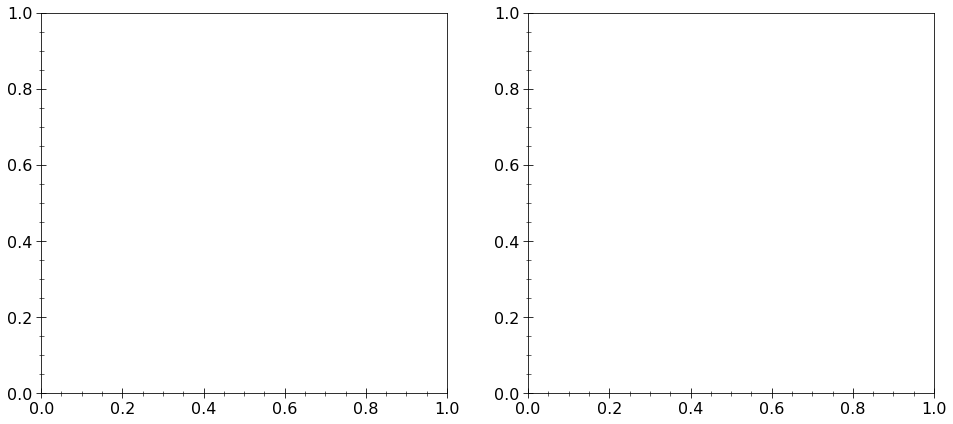

In [3]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
for i in [0,1,2,10,99]:
    ax[0].plot(Ha,data[1][i,0],label=i)
plt.figlegend(fontsize=18,ncol=5,bbox_to_anchor=(0.6,0.96),columnspacing=0.8,handlelength=1.5)
for i in [0,1,2,10,99]:
    ax[1].plot(Vars.Lat,data[0][i,0])
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
line1=ax[0].plot(Year_NorESM,NORESM_1990_2005,c='k',linewidth=1.7,label='NorESM-Target Pinatubo Response')
line2=ax[1].plot(Lat_10,ZMT_10,c='k',linewidth=1.7,label='ERA-Target ZMT')
ax[1].set_xticks(np.linspace(-90,90,7)), ax[1].set_xlim(-90,90)
ax[0].set_xlabel('Time'),ax[0].set_ylabel('$T_{response}$ [K]')
ax[1].set_xlabel('Lat'),ax[1].set_ylabel('$T_{zonal mean}$ [K]')
ax[0].set_xticks(np.linspace(1990,2005,4)), ax[0].set_xlim(1989.8,2005.2)
ax[0].legend((line1),['NorESM-Target Pinatubo Response'],fontsize=13,loc='upper right')
ax[1].legend((line2),['ERA-Target ZMT'],fontsize=13,loc='upper right')
#plt.figlegend(fontsize=18,ncol=5,bbox_to_anchor=(0.6,0.96),columnspacing=0.8,handlelength=1.5)
#plt.xlim(1808,1858)
plt.savefig('Data/Coupled_Optimization_BudykoRup_010.eps',format='EPS',bbox_inches='tight')

In [10]:
#setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
#labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P=[3.02794273e+08, 4.80868504e-01, 2.47299528e-15, 1.16506701e+00, 1.16500290e+00, 1.16499030e+00]
#P1=[2.10056979e+08, 5.00042362e-01, 2.01124229e-15, 1.16500050e+00,1.16500009e+00, 1.16500191e+00]
P=[ -7.09368689, -24.3554691,  -36.65052905, -47.96235225, -49.82912432,
   -49.07644568, -46.95244629, -45.62632961, -44.43208399, -43.93356111,
 -43.94788769, -42.54654785, -40.14638466, -31.07944123, -38.64653433,
 -31.9551132 , -20.29119435,  -5.61999035]
labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['rk4input'],config_CTRL['funccomp'],progressbar=True)
ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_Offset.ini')
variable_importer(config_base,initialZMT=False)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config=add_parameters(config_base,P,labels)
Vars.T,Vars.T_global=ZMT,GMT   
data1=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini



Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


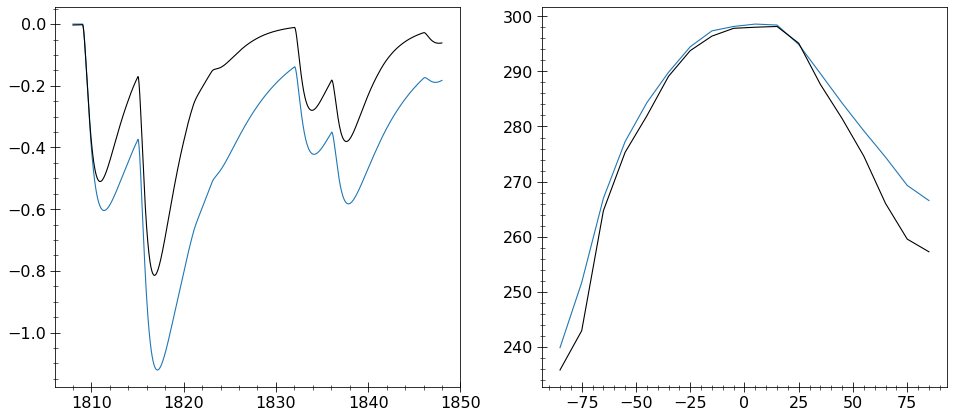

In [12]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
#ax[0].plot(data[0]/constants.time_sec_year,data[2]-data[2][0])
ax[0].plot(data1[0]/const.time_sec_year,data1[2]-data1[2][0])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')

elevation=-0.0065*np.array(ParasCTRL[1][1])
#ax[1].plot(Vars.Lat,data[1][0]+elevation)
ax[1].plot(Vars.Lat,data1[1][0]+elevation)
ax[1].plot(Lat_10,ZMT_10,c='k')

#plt.savefig('Coupled_Optimization.eps',format='EPS')